## Load dataset and format it in the required form.

In [281]:
body_dataframe = pd.read_csv('dbworld_bodies_stemmed.csv')
subject_dataframe = pd.read_csv('dbworld_subjects_stemmed.csv')

body_dataframe.drop(columns = ['id'],inplace=True)
subject_dataframe.drop(columns = ['id'],inplace=True)
display(body_dataframe)
display(subject_dataframe)

,000euro,05102011,10th,11th,12noon,12th,13th,14th,15th,16th,19th,1st,2011,2011website,2012call,20details,20fellow,20position,20postdoctoral,20th,21st,25th,28th,29th,30th,31st,31th,3rd,4a11,4th,503â,59â,5pm,5th,62afb35d,64ded197043a,6th,714c,75k,7th,...,yang,yanjiang,yao,yare,yenduri,yeo,yile,yoav,yolanda,york,young,younosuk,yuan,yuanchun,yue,yuka,yung,zahir,zaiq,zaragoza,zaslavski,zeeland,zenghua,zhang,zhao,zhejiang,zhenkai,zhongxuan,zhou,ziyang,znie,zurich,zürich,ètop,özsu,û37,û42,û46,û56,CLASS
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,10th,13th,1st,2nd,31st,3rd,5th,6th,abstract,academ,access,acm,acn,advanc,aie,algorithm,analysi,analyt,antil,appli,applic,area,asia,assist,associ,augment,australia,autonom,base,big,bournemouth,call,centr,certif,ceur,cfp,chicago,chile,china,citi,...,servic,session,sigmod,smpe,soa,social,spain,spatial,special,steven,stream,studentship,submiss,symposuim,system,technic,technolog,tempor,tenur,tist,tomorrow,track,trento,trust,tue,tutori,ubiquit,unit,univers,usa,vacanc,valencia,vehicular,video,web,wireless,workflow,workshop,zurich,CLASS
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [282]:
ham_count = len(body_dataframe[body_dataframe['CLASS'] == 1])
spam_count = len(body_dataframe[body_dataframe['CLASS'] == 0])
test_size = 0.2
ham_train_size = int(round((1-test_size)*ham_count,0))
spam_train_size = int(round((1-test_size)*spam_count,0))

print("Training set will have",ham_train_size,"ham emails and",spam_train_size,"spam emails")
print("Test set will have",ham_count-ham_train_size,"ham emails and",spam_count-spam_train_size,"spam emails")

Training set will have 23 ham emails and 28 spam emails
Test set will have 6 ham emails and 7 spam emails


In [283]:
from sklearn.model_selection import train_test_split

#divide train and test into 80% and 20%
#Split the data into train and test for subject
subject_dataframe_train_ham, subject_dataframe_test_ham, subject_class_train_ham, subject_class_test_ham = train_test_split(
    subject_dataframe[subject_dataframe['CLASS'] == 1].drop(columns=['CLASS']),subject_dataframe[subject_dataframe['CLASS'] == 1]['CLASS'], test_size=0.2)
subject_dataframe_train_spam, subject_dataframe_test_spam, subject_class_train_spam, subject_class_test_spam = train_test_split(
    subject_dataframe[subject_dataframe['CLASS'] == 0].drop(columns=['CLASS']),subject_dataframe[subject_dataframe['CLASS'] == 0]['CLASS'], test_size=0.2)

subject_dataframe_train = pd.concat([subject_dataframe_train_spam,subject_dataframe_train_ham])
subject_class_train = pd.concat([subject_class_train_spam,subject_class_train_ham])
subject_dataframe_test = pd.concat([subject_dataframe_test_spam,subject_dataframe_test_ham])
subject_class_test = pd.concat([subject_class_test_spam,subject_class_test_ham])

#Split the data into train and test for body
body_dataframe_train_ham, body_dataframe_test_ham, body_class_train_ham, body_class_test_ham = train_test_split(
    body_dataframe[body_dataframe['CLASS'] == 1].drop(columns=['CLASS']),body_dataframe[body_dataframe['CLASS'] == 1]['CLASS'], test_size=0.2)
body_dataframe_train_spam, body_dataframe_test_spam, body_class_train_spam, body_class_test_spam = train_test_split(
    body_dataframe[body_dataframe['CLASS'] == 0].drop(columns=['CLASS']),body_dataframe[body_dataframe['CLASS'] == 0]['CLASS'], test_size=0.2)

body_dataframe_train = pd.concat([body_dataframe_train_spam,body_dataframe_train_ham])
body_class_train = pd.concat([body_class_train_spam,body_class_train_ham])
body_dataframe_test = pd.concat([body_dataframe_test_spam,body_dataframe_test_ham])
body_class_test = pd.concat([body_class_test_spam,body_class_test_ham])

# **a) Naive Bayes implementation with laplacian smoothening**

In [284]:
import numpy as np
import pandas as pd
import random
import string

def get_random_string(length):
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

def prior_probability(dataframe):
    ham_length = len(dataframe[dataframe['CLASS'] == 1])
    spam_length = len(dataframe[dataframe['CLASS'] == 0])
    prior_ham = (ham_length)/(ham_length+spam_length)
    prior_spam = (spam_length)/(ham_length+spam_length)  
    return prior_ham,prior_spam

def spam_ham_probability(prob_dict,prior,words,missing_word):
    probs = [prior]
    for w in words:
        try:
            probs.append(prob_dict[w])
        except:
            probs.append(prob_dict[missing_word])
    probs = np.prod(probs)
    return probs

def predict_spam_email(words,p_ham_dict,p_spam_dict,prior_ham,prior_spam,missing_word):
    import numpy as np
    words = [x for x in words if x!= 'CLASS']
    prob_w_ham = spam_ham_probability(p_ham_dict,prior_ham,words,missing_word)
    prob_w_spam = spam_ham_probability(p_spam_dict,prior_spam,words,missing_word)
    if prob_w_spam > prob_w_ham:
        return 0
    else:
        return 1

def predict(dataframe,missing_word):
    pred_ls = []
    for index, row in dataframe.iterrows():
        words = list(row[row >0].index)
        pred_ls.append(predict_spam_email(words,p_ham_dict,p_spam_dict,prior_ham,prior_spam,missing_word))
    print("Final email predictions: ",pred_ls)
    return pred_ls

def fit(dataframe,lap_coeff):
    num_words_ham = dataframe[dataframe['CLASS'] == 1][dataframe.columns[:-1]].values.sum()
    num_words_spam = dataframe[dataframe['CLASS'] == 0][dataframe.columns[:-1]].values.sum()
    vocabulary_size = len(dataframe.columns)
    
    print("Number of ham words:",num_words_ham)
    print("Number of spam words:",num_words_spam)
    print("Total number of words:",vocabulary_size,"\n")

    prob_ham_dict = dict()
    prob_spam_dict = dict()
    
    for w in dataframe.columns[:-1]: 
        num_w_spam = dataframe[dataframe['CLASS'] == 0][w].values.sum() 
        prob_w_spam = (float(num_w_spam) + lap_coeff)/(float(num_words_spam) + lap_coeff*vocabulary_size) 
        num_w_ham = dataframe[dataframe['CLASS'] == 1][w].values.sum() 
        prob_w_ham = (float(num_w_ham) + lap_coeff)/(float(num_words_ham) + lap_coeff*vocabulary_size) 
        prob_ham_dict[w] = prob_w_ham
        prob_spam_dict[w] = prob_w_spam

    missing_word = 'missing_word'
    try: 
        prob_ham_dict[missing_word]
        missing_word+='_'+get_random_string(20)
        print("Key existed so new missing_word is:",missing_word)
    except:
        pass

    prob_missing_word_ham = (lap_coeff)/(float(num_words_ham) + lap_coeff*vocabulary_size) 
    prob_missing_word_spam = (lap_coeff)/(float(num_words_spam) + lap_coeff*vocabulary_size) 
    prob_ham_dict[missing_word] = prob_missing_word_ham
    prob_spam_dict[missing_word] = prob_missing_word_spam
    
    return prob_ham_dict,prob_spam_dict,missing_word 

# **b)Train and test the created model for each dataset**

In [285]:
subject_dataframe_train['CLASS'] = subject_class_train

prior_ham,prior_spam = prior_probability(subject_dataframe_train) 
print("Prior probability of ham is",prior_ham, "and for spam is",prior_spam)

alpha = 1.0
p_ham_dict,p_spam_dict,missing_word = fit(subject_dataframe_train,alpha) 

Prior probability of ham is 0.45098039215686275 and for spam is 0.5490196078431373
Number of ham words: 155
Number of spam words: 173
Total number of words: 230 



In [286]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib

def fMeasure(actual,predicted):
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    recall = tp/(tp+fn)  
    precision = tp/(tp+fp)
    return (2*precision*recall)/(precision+recall)

def plot_confusion_matrix_spam_classifier(actual,predicted,title):
    matplotlib.rcParams['font.size'] = 18
    fig, ax = plt.subplots()
    
    tn, fp, fn, tp = confusion_matrix(actual,predicted).ravel()

    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(actual,predicted),display_labels = ["Spam","Ham"])
    disp.plot(cmap = "tab10", ax = ax)

    ax.set_title(title)
    
    plt.xlabel("Actual Result")
    plt.ylabel("Predicted Result")
    plt.savefig(title.replace(" ","_")+"_confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)

Final email predictions:  [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
F-measure: 0.8333333333333334


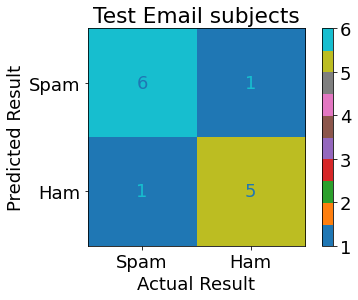

In [287]:
predictions = predict(subject_dataframe_test,missing_word) 
print("F-measure:",fMeasure(subject_class_test,predictions)) 
plot_confusion_matrix_spam_classifier(subject_class_test,predictions,'Test Email subjects') 

Final email predictions:  [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
F-measure: 0.7058823529411764


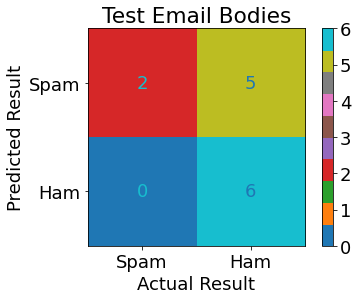

In [288]:
predictions = predict(body_dataframe_test,missing_word) 
print("F-measure:",fMeasure(body_class_test,predictions)) 
plot_confusion_matrix_spam_classifier(body_class_test,predictions,'Test Email Bodies') 

If we compare the f-measure for email subjects and email bodies, we can see that subject gives a better classification result. Even after running it multiple times it gives the same result. So for spam email filtering, subject is a better data than the body.

# **c) Compare with sklearn implementation**

In [289]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
try: 
    model.fit(subject_dataframe_train.drop(columns=['CLASS']), subject_class_train)
except:
    model.fit(subject_dataframe_train, subject_class_train)

F-measure: 0.8333333333333334


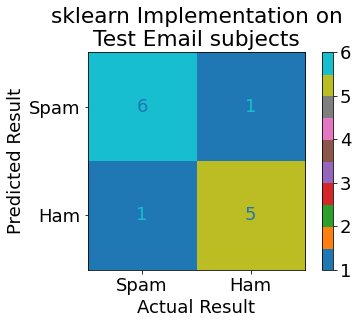

In [290]:

prediction = model.predict(subject_dataframe_test)
print("F-measure:",fMeasure(subject_class_test,prediction))
plot_confusion_matrix_spam_classifier(subject_class_test,prediction,'sklearn Implementation on\nTest Email subjects')

In [291]:
model = MultinomialNB()
try: 
    model.fit(body_dataframe_train.drop(columns=['CLASS']), body_class_train)
except:
    model.fit(body_dataframe_train, body_class_train)

F-measure: 0.9090909090909091


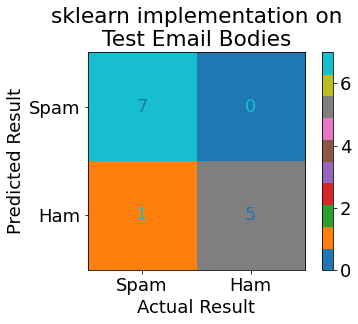

In [292]:
prediction = model.predict(body_dataframe_test)
print("F-measure:",fMeasure(body_class_test,prediction))
plot_confusion_matrix_spam_classifier(body_class_test,prediction,'sklearn implementation on\nTest Email Bodies')